In [10]:
!pip install textattack pyarrow==1.0 sentence-transformers > /dev/null

In [11]:
from nltk.corpus import wordnet

import textattack
from textattack.transformations.word_swap import WordSwap


class WordSwapWordNetAntonym(WordSwap):
    """Transforms an input by replacing its words with synonyms provided by
    WordNet."""

    def _get_replacement_words(self, word, random=False):
        """Returns a list containing all possible words with 1 character
        replaced by a homoglyph."""
        antonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                  for ant_lemma in lemma.antonyms():
                    ant_word = ant_lemma.name()
                    if (
                        (ant_word != word)
                        and ("_" not in ant_word)
                        and (textattack.shared.utils.is_one_word(ant_word))
                    ):
                        # WordNet can suggest phrases that are joined by '_' but we ignore phrases.
                        antonyms.add(ant_word)
        return list(antonyms)

In [12]:
def set_seed(random_seed):
  import random
  random.seed(random_seed)
  import numpy as np
  np.random.seed(random_seed)
  import torch
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)

set_seed(42)

In [13]:
import torch
import textattack

class FoolConstraintGoalFunction(textattack.goal_functions.classification.UntargetedClassification):
  def __init__(self, constraint, min_acceptable_score=0.8,
                num_words_to_swap=2):
    self.constraint = constraint
    self.query_budget = float("inf")
    self.min_acceptable_score = min_acceptable_score
    self.use_cache = False
    self.num_words_to_swap = num_words_to_swap
    self.maximizable = False
    self.model_cache_size = 0
  
  def _should_skip(self, *_):
    return False
  
  def _is_goal_complete(self, model_output, attacked_text):
    num_words_swapped = len(attacked_text.attack_attrs.get('modified_indices', []))
    model_score =  model_output.item()

    return (num_words_swapped >= self.num_words_to_swap) and (model_score >= self.min_acceptable_score)

  def _call_model(self, attacked_text_list):
    """ Gets predictions for a list of `AttackedText` objects.

    Gets prediction from cache if possible. If prediction is not in the 
    cache, queries model and stores prediction in cache.
    """
    original_text = attacked_text_list[0]
    while "previous_attacked_text" in original_text.attack_attrs:
      original_text = original_text.attack_attrs["previous_attacked_text"]

    scores = []
    for at in attacked_text_list:
      if "newly_modified_indices" not in at.attack_attrs:
        # Original text
        scores.append([1.0])
      else:
        at.attack_attrs["last_transformation"] = transformation
        if isinstance(self.constraint, BERTScore):
          # call bert scorer specially
          model_scores = self.constraint._bert_scorer.score([original_text.text], [at.text])
        else:
          # otherwise, it's a sentence encoder
          model_scores = self.constraint._score_list(original_text, [at])
        scores.append([model_scores[0]])
    return torch.tensor(scores)
      
  def _get_score(self, model_output, attacked_text):
    model_score =  model_output.item()
    if model_score < self.min_acceptable_score:
      return 0.0

    num_words_swapped = len(attacked_text.attack_attrs.get('modified_indices', []))
    num_words = len(attacked_text.words)
    num_words_score = (num_words_swapped / num_words)
    return num_words_swapped + model_score

In [14]:
from textattack.constraints.grammaticality.language_models import GPT2
from textattack.constraints.semantics import BERTScore
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
from textattack.constraints.pre_transformation import InputColumnModification, RepeatModification, StopwordModification
from textattack.datasets import HuggingFaceNlpDataset
from textattack.search_methods import BeamSearch
from textattack.shared import Attack
from textattack.transformations import WordSwapEmbedding

import numpy as np
import tqdm

transformation = WordSwapWordNetAntonym()

# We'll constrain modification of already modified indices and stopwords
constraints = [RepeatModification(), StopwordModification()]
# don't attack premise in entailment
constraints.append(InputColumnModification(["premise", "hypothesis"], {"premise"}))
# use GPT2 to try and make sentences somewhat plausible
constraints.append(GPT2(max_log_prob_diff=2.0))

# Use SST-2 dataset
dataset = HuggingFaceNlpDataset("glue", "sst2", "validation", shuffle=True)

data = []

num_samples = 100
num_words_to_swap = 3

all_constraints = ('bertscore', 'use')
threshold_vals = np.arange(.50, 1.0, .01)
for constraint_idx, constraint_name in enumerate(all_constraints):
  tqdm.tqdm.write(f'----> constraint {constraint_name}')

  # We know this second-order attack fails most of the time, and fails more as the 
  # threshold increases. Any example that fails will continue to fail. We take 
  # advantage of this fact through caching.
  known_failure_idxs = set()

  if constraint_name == 'bertscore':
    constraint = BERTScore(
      min_bert_score=0.0, # don't need this
      model="bert-base-uncased",
      score_type="f1",
      compare_against_original=True,
    )
  else:
    constraint = UniversalSentenceEncoder(
      compare_against_original=True,
      skip_text_shorter_than_window=False,
    )
  for threshold_idx, threshold in enumerate(threshold_vals):
    # goal function is to fool a single constraint
    tqdm.tqdm.write(f'--> Threshold {threshold} / Num words to swap {num_words_to_swap}')
    goal_function = FoolConstraintGoalFunction(
      constraint,
      min_acceptable_score=threshold,
      num_words_to_swap=num_words_to_swap,
    )

    # search method
    search_method = BeamSearch(beam_width=2)
    # Now, let's make the attack from the 4 components:
    attack = Attack(goal_function, constraints, transformation, search_method)
    idxs_to_attack = set(range(num_samples)) - known_failure_idxs
    idxs_to_attack = list(sorted(idxs_to_attack))

    if len(idxs_to_attack):
      this_sample_idx = (constraint_idx * len(threshold_vals)) + threshold_idx + 1
      total_num_samples = len(all_constraints) * len(threshold_vals)
      results_iterable = list(tqdm.tqdm(attack.attack_dataset(dataset, 
                                      indices=idxs_to_attack), 
                                      total=len(idxs_to_attack), 
                                      position=0, 
                                      leave=True, desc=f'Sample {this_sample_idx}/{total_num_samples}'))
    else:
      results_iterable = []


    num_successes = 0
    for result_idx, result in zip(idxs_to_attack, results_iterable):
      if isinstance(result, textattack.attack_results.FailedAttackResult):
        known_failure_idxs.add(result_idx)
      elif isinstance(result, textattack.attack_results.SuccessfulAttackResult):
        num_successes += 1
      
    data.append({ 
        'constraint': type(constraint).__name__, 
        'threshold': threshold, 
        'num_successes': num_successes, 
        'num_words_to_swap': num_words_to_swap 
      })

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
textattack: Loading nlp dataset glue, subset sst2, split validation.


----> constraint bertscore


Sample 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

--> Threshold 0.5 / Num words to swap 3


Sample 2/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.51 / Num words to swap 3


Sample 3/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.52 / Num words to swap 3


Sample 4/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.53 / Num words to swap 3


Sample 5/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.54 / Num words to swap 3


Sample 6/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.55 / Num words to swap 3


Sample 7/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.56 / Num words to swap 3


Sample 8/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.5700000000000001 / Num words to swap 3


Sample 9/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.5800000000000001 / Num words to swap 3


Sample 10/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.5900000000000001 / Num words to swap 3


Sample 11/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6000000000000001 / Num words to swap 3


Sample 12/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6100000000000001 / Num words to swap 3


Sample 13/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6200000000000001 / Num words to swap 3


Sample 14/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6300000000000001 / Num words to swap 3


Sample 15/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6400000000000001 / Num words to swap 3


Sample 16/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6500000000000001 / Num words to swap 3


Sample 17/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6600000000000001 / Num words to swap 3


Sample 18/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6700000000000002 / Num words to swap 3


Sample 19/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6800000000000002 / Num words to swap 3


Sample 20/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6900000000000002 / Num words to swap 3


Sample 21/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7000000000000002 / Num words to swap 3


Sample 22/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7100000000000002 / Num words to swap 3


Sample 23/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7200000000000002 / Num words to swap 3


Sample 24/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7300000000000002 / Num words to swap 3


Sample 25/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7400000000000002 / Num words to swap 3


Sample 26/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7500000000000002 / Num words to swap 3


Sample 27/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7600000000000002 / Num words to swap 3


Sample 28/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7700000000000002 / Num words to swap 3


Sample 29/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7800000000000002 / Num words to swap 3


Sample 30/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7900000000000003 / Num words to swap 3


Sample 31/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.8000000000000003 / Num words to swap 3


Sample 32/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.8100000000000003 / Num words to swap 3


Sample 33/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.8200000000000003 / Num words to swap 3


Sample 34/100:   0%|          | 0/48 [00:00<?, ?it/s]

--> Threshold 0.8300000000000003 / Num words to swap 3


Sample 35/100:   0%|          | 0/48 [00:00<?, ?it/s]

--> Threshold 0.8400000000000003 / Num words to swap 3


Sample 36/100:   0%|          | 0/48 [00:00<?, ?it/s]

--> Threshold 0.8500000000000003 / Num words to swap 3


Sample 37/100:   0%|          | 0/47 [00:00<?, ?it/s]

--> Threshold 0.8600000000000003 / Num words to swap 3


Sample 38/100:   0%|          | 0/45 [00:00<?, ?it/s]

--> Threshold 0.8700000000000003 / Num words to swap 3


Sample 39/100:   0%|          | 0/44 [00:00<?, ?it/s]

--> Threshold 0.8800000000000003 / Num words to swap 3


Sample 40/100:   0%|          | 0/43 [00:00<?, ?it/s]

--> Threshold 0.8900000000000003 / Num words to swap 3


Sample 41/100:   0%|          | 0/41 [00:00<?, ?it/s]

--> Threshold 0.9000000000000004 / Num words to swap 3


Sample 42/100:   0%|          | 0/39 [00:00<?, ?it/s]

--> Threshold 0.9100000000000004 / Num words to swap 3


Sample 43/100:   0%|          | 0/38 [00:00<?, ?it/s]

--> Threshold 0.9200000000000004 / Num words to swap 3


Sample 44/100:   0%|          | 0/35 [00:00<?, ?it/s]

--> Threshold 0.9300000000000004 / Num words to swap 3


Sample 45/100:   0%|          | 0/32 [00:00<?, ?it/s]

--> Threshold 0.9400000000000004 / Num words to swap 3


Sample 46/100:   0%|          | 0/22 [00:00<?, ?it/s]

--> Threshold 0.9500000000000004 / Num words to swap 3


Sample 47/100:   0%|          | 0/16 [00:00<?, ?it/s]

--> Threshold 0.9600000000000004 / Num words to swap 3


Sample 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.9700000000000004 / Num words to swap 3


Sample 49/100:   0%|          | 0/2 [00:00<?, ?it/s]

--> Threshold 0.9800000000000004 / Num words to swap 3


Sample 49/100: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


--> Threshold 0.9900000000000004 / Num words to swap 3
----> constraint use


Sample 51/100:   0%|          | 0/100 [00:00<?, ?it/s]

--> Threshold 0.5 / Num words to swap 3


Sample 52/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.51 / Num words to swap 3


Sample 53/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.52 / Num words to swap 3


Sample 54/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.53 / Num words to swap 3


Sample 55/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.54 / Num words to swap 3


Sample 56/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.55 / Num words to swap 3


Sample 57/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.56 / Num words to swap 3


Sample 58/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.5700000000000001 / Num words to swap 3


Sample 59/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.5800000000000001 / Num words to swap 3


Sample 60/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.5900000000000001 / Num words to swap 3


Sample 61/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6000000000000001 / Num words to swap 3


Sample 62/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6100000000000001 / Num words to swap 3


Sample 63/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6200000000000001 / Num words to swap 3


Sample 64/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6300000000000001 / Num words to swap 3


Sample 65/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6400000000000001 / Num words to swap 3


Sample 66/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6500000000000001 / Num words to swap 3


Sample 67/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6600000000000001 / Num words to swap 3


Sample 68/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6700000000000002 / Num words to swap 3


Sample 69/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6800000000000002 / Num words to swap 3


Sample 70/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.6900000000000002 / Num words to swap 3


Sample 71/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7000000000000002 / Num words to swap 3


Sample 72/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7100000000000002 / Num words to swap 3


Sample 73/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7200000000000002 / Num words to swap 3


Sample 74/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7300000000000002 / Num words to swap 3


Sample 75/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7400000000000002 / Num words to swap 3


Sample 76/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7500000000000002 / Num words to swap 3


Sample 77/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.7600000000000002 / Num words to swap 3


Sample 78/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.7700000000000002 / Num words to swap 3


Sample 79/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.7800000000000002 / Num words to swap 3


Sample 80/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.7900000000000003 / Num words to swap 3


Sample 81/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.8000000000000003 / Num words to swap 3


Sample 82/100:   0%|          | 0/48 [00:00<?, ?it/s]

--> Threshold 0.8100000000000003 / Num words to swap 3


Sample 83/100:   0%|          | 0/44 [00:00<?, ?it/s]

--> Threshold 0.8200000000000003 / Num words to swap 3


Sample 84/100:   0%|          | 0/40 [00:00<?, ?it/s]

--> Threshold 0.8300000000000003 / Num words to swap 3


Sample 85/100:   0%|          | 0/36 [00:00<?, ?it/s]

--> Threshold 0.8400000000000003 / Num words to swap 3


Sample 86/100:   0%|          | 0/32 [00:00<?, ?it/s]

--> Threshold 0.8500000000000003 / Num words to swap 3


Sample 87/100:   0%|          | 0/31 [00:00<?, ?it/s]

--> Threshold 0.8600000000000003 / Num words to swap 3


Sample 88/100:   0%|          | 0/29 [00:00<?, ?it/s]

--> Threshold 0.8700000000000003 / Num words to swap 3


Sample 89/100:   0%|          | 0/23 [00:00<?, ?it/s]

--> Threshold 0.8800000000000003 / Num words to swap 3


Sample 90/100:   0%|          | 0/20 [00:00<?, ?it/s]

--> Threshold 0.8900000000000003 / Num words to swap 3


Sample 91/100:   0%|          | 0/16 [00:00<?, ?it/s]

--> Threshold 0.9000000000000004 / Num words to swap 3


Sample 92/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.9100000000000004 / Num words to swap 3


Sample 93/100:   0%|          | 0/4 [00:00<?, ?it/s]

--> Threshold 0.9200000000000004 / Num words to swap 3


Sample 94/100:   0%|          | 0/2 [00:00<?, ?it/s]

--> Threshold 0.9300000000000004 / Num words to swap 3


Sample 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

--> Threshold 0.9400000000000004 / Num words to swap 3


Sample 95/100: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

--> Threshold 0.9500000000000004 / Num words to swap 3
--> Threshold 0.9600000000000004 / Num words to swap 3
--> Threshold 0.9700000000000004 / Num words to swap 3
--> Threshold 0.9800000000000004 / Num words to swap 3
--> Threshold 0.9900000000000004 / Num words to swap 3


#### Experiment 2

In [6]:
from textattack.constraints.grammaticality.language_models import GPT2
from textattack.constraints.semantics import BERTScore
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
from textattack.constraints.pre_transformation import InputColumnModification, RepeatModification, StopwordModification
from textattack.datasets import HuggingFaceNlpDataset
from textattack.goal_functions import UntargetedClassification
from textattack.search_methods import GreedyWordSwapWIR
from textattack.shared import Attack
from textattack.transformations import WordSwapEmbedding

import numpy as np
import torch
import tqdm

transformation = WordSwapEmbedding()

import textattack
import transformers

# We'll constrain modification of already modified indices and stopwords
constraints = [RepeatModification(), StopwordModification()]
# don't attack premise in entailment
constraints.append(InputColumnModification(["premise", "hypothesis"], {"premise"}))
# use GPT2 to try and make sentences somewhat plausible
constraints.append(GPT2(max_log_prob_diff=2.0))

# Use SST-2 dataset
dataset = HuggingFaceNlpDataset("glue", "sst2", "validation", shuffle=True)

data2 = []

all_constraints = ('bertscore', 'use')
threshold_vals = np.arange(.50, 1.0, .01)[::-1] # start with highest constraint level!

all_models = ("textattack/bert-base-uncased-SST-2", "textattack/albert-base-v2-SST-2", "textattack/distilbert-base-cased-SST-2")
for model_idx, model_path in enumerate(all_models):
  # model to attack & goal function
  print('Model -->', model_path)
  tokenizer = textattack.models.tokenizers.AutoTokenizer(model_path)
  model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path)
  model = textattack.models.wrappers.HuggingFaceModelWrapper(model, tokenizer, batch_size=16)
  goal_function = UntargetedClassification(model)
  for constraint_idx, constraint_name in enumerate(all_constraints):
    print(f'----> constraint {constraint_name}')
    # We know this first-order succeeds fails most of the time, and succeeds more as the 
    # threshold decreases. Any example that succeeds will continue to succeed. We take 
    # advantage of this fact through caching.
    known_success_idxs = set()
    if constraint_name == 'use':
        constraint = UniversalSentenceEncoder(
        threshold=0.0,
        compare_against_original=True,
        skip_text_shorter_than_window=False,
      )
    else:
      constraint = BERTScore(
        min_bert_score=0.0, # don't need this
        model="bert-base-uncased",
        score_type="f1",
        compare_against_original=True,
      )
    for threshold_idx, threshold in enumerate(threshold_vals):
      if constraint_name == 'use':
        constraint.threshold = threshold
      else:
        constraint.min_bert_score = threshold
      print(f'--> Threshold {threshold}')
      these_constraints = constraints + [constraint]
      # search method
      search_method = GreedyWordSwapWIR()
      # Now, let's make the attack from the 4 components:
      attack = Attack(goal_function, these_constraints, transformation, search_method)

      # calculate all the idxs we don't know succeed already and use this to
      # avoid recomputing unnecessary attacks
      idxs_to_attack = set(range(num_samples)) - known_success_idxs
      idxs_to_attack = sorted(list(idxs_to_attack))

      if len(idxs_to_attack):
        this_sample_idx = (constraint_idx * len(threshold_vals)) + threshold_idx + 1
        total_num_samples = len(all_constraints) * len(threshold_vals)
        results_iterable = list(
            tqdm.tqdm(attack.attack_dataset(dataset, indices=idxs_to_attack),
                total=len(idxs_to_attack), 
                position=0, leave=True, 
                desc=f'Sample {this_sample_idx}/{total_num_samples}')
            )
      else:
        results_iterable = []
      
      # num_successes = len([r for r in results_iterable if isinstance(r, textattack.attack_results.SuccessfulAttackResult)])
      for result_idx, result in zip(idxs_to_attack, results_iterable):
        if isinstance(result, textattack.attack_results.SuccessfulAttackResult):
          known_success_idxs.add(result_idx)
      num_successes = len(known_success_idxs)

      data2.append({ 
          'constraint': type(constraint).__name__, 
          'threshold': threshold, 
          'model': model_path,
          # 'results': results_iterable,
          'num_successes': num_successes
        })

textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:12<00:00, 38.5MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpvg1wm747.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
textattack: Loading nlp dataset glue, subset sst2, split validation.


Model --> textattack/bert-base-uncased-SST-2


textattack: Unknown if model of class <class 'textattack.models.wrappers.huggingface_model_wrapper.HuggingFaceModelWrapper'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


----> constraint bertscore


Sample 1/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9900000000000004


Sample 2/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9800000000000004


Sample 3/100:   0%|          | 0/48 [00:00<?, ?it/s]

--> Threshold 0.9700000000000004


Sample 4/100:   0%|          | 0/45 [00:00<?, ?it/s]

--> Threshold 0.9600000000000004


Sample 5/100:   0%|          | 0/44 [00:00<?, ?it/s]

--> Threshold 0.9500000000000004


Sample 6/100:   0%|          | 0/41 [00:00<?, ?it/s]

--> Threshold 0.9400000000000004


Sample 7/100:   0%|          | 0/40 [00:00<?, ?it/s]

--> Threshold 0.9300000000000004


Sample 8/100:   0%|          | 0/38 [00:00<?, ?it/s]

--> Threshold 0.9200000000000004


Sample 9/100:   0%|          | 0/36 [00:00<?, ?it/s]

--> Threshold 0.9100000000000004


Sample 10/100:   0%|          | 0/34 [00:00<?, ?it/s]

--> Threshold 0.9000000000000004


Sample 11/100:   0%|          | 0/32 [00:00<?, ?it/s]

--> Threshold 0.8900000000000003


Sample 12/100:   0%|          | 0/31 [00:00<?, ?it/s]

--> Threshold 0.8800000000000003


Sample 13/100:   0%|          | 0/31 [00:00<?, ?it/s]

--> Threshold 0.8700000000000003


Sample 14/100:   0%|          | 0/31 [00:00<?, ?it/s]

--> Threshold 0.8600000000000003


Sample 15/100:   0%|          | 0/29 [00:00<?, ?it/s]

--> Threshold 0.8500000000000003


Sample 16/100:   0%|          | 0/27 [00:00<?, ?it/s]

--> Threshold 0.8400000000000003


Sample 17/100:   0%|          | 0/25 [00:00<?, ?it/s]

--> Threshold 0.8300000000000003


Sample 18/100:   0%|          | 0/24 [00:00<?, ?it/s]

--> Threshold 0.8200000000000003


Sample 19/100:   0%|          | 0/22 [00:00<?, ?it/s]

--> Threshold 0.8100000000000003


Sample 20/100:   0%|          | 0/20 [00:00<?, ?it/s]

--> Threshold 0.8000000000000003


Sample 21/100:   0%|          | 0/19 [00:00<?, ?it/s]

--> Threshold 0.7900000000000003


Sample 22/100:   0%|          | 0/19 [00:00<?, ?it/s]

--> Threshold 0.7800000000000002


Sample 23/100:   0%|          | 0/18 [00:00<?, ?it/s]

--> Threshold 0.7700000000000002


Sample 24/100:   0%|          | 0/18 [00:00<?, ?it/s]

--> Threshold 0.7600000000000002


Sample 25/100:   0%|          | 0/17 [00:00<?, ?it/s]

--> Threshold 0.7500000000000002


Sample 26/100:   0%|          | 0/17 [00:00<?, ?it/s]

--> Threshold 0.7400000000000002


Sample 27/100:   0%|          | 0/15 [00:00<?, ?it/s]

--> Threshold 0.7300000000000002


Sample 28/100:   0%|          | 0/15 [00:00<?, ?it/s]

--> Threshold 0.7200000000000002


Sample 29/100:   0%|          | 0/15 [00:00<?, ?it/s]

--> Threshold 0.7100000000000002


Sample 30/100:   0%|          | 0/14 [00:00<?, ?it/s]

--> Threshold 0.7000000000000002


Sample 31/100:   0%|          | 0/14 [00:00<?, ?it/s]

--> Threshold 0.6900000000000002


Sample 32/100:   0%|          | 0/14 [00:00<?, ?it/s]

--> Threshold 0.6800000000000002


Sample 33/100:   0%|          | 0/14 [00:00<?, ?it/s]

--> Threshold 0.6700000000000002


Sample 34/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.6600000000000001


Sample 35/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.6500000000000001


Sample 36/100:   0%|          | 0/12 [00:00<?, ?it/s]

--> Threshold 0.6400000000000001


Sample 37/100:   0%|          | 0/12 [00:00<?, ?it/s]

--> Threshold 0.6300000000000001


Sample 38/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6200000000000001


Sample 39/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6100000000000001


Sample 40/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6000000000000001


Sample 41/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.5900000000000001


Sample 42/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.5800000000000001


Sample 43/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.5700000000000001


Sample 44/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.56


Sample 45/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.55


Sample 46/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.54


Sample 47/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.53


Sample 48/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.52


Sample 49/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.51


Sample 50/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.5


Sample 50/100: 100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


----> constraint use


Exception ignored in: <bound method CapturableResourceDeleter.__del__ of <tensorflow.python.training.tracking.tracking.CapturableResourceDeleter object at 0x7f422fe28d68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py", line 202, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 823, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 697, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 2855, in _get_concrete_function_internal_garbage_collected
    graph_function, _, _ = self._maybe

--> Threshold 0.9900000000000004


Sample 52/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9800000000000004


Sample 53/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9700000000000004


Sample 54/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9600000000000004


Sample 55/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9500000000000004


Sample 56/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.9400000000000004


Sample 57/100:   0%|          | 0/48 [00:00<?, ?it/s]

--> Threshold 0.9300000000000004


Sample 58/100:   0%|          | 0/48 [00:00<?, ?it/s]

--> Threshold 0.9200000000000004


Sample 59/100:   0%|          | 0/45 [00:00<?, ?it/s]

--> Threshold 0.9100000000000004


Sample 60/100:   0%|          | 0/45 [00:00<?, ?it/s]

--> Threshold 0.9000000000000004


Sample 61/100:   0%|          | 0/45 [00:00<?, ?it/s]

--> Threshold 0.8900000000000003


Sample 62/100:   0%|          | 0/41 [00:00<?, ?it/s]

--> Threshold 0.8800000000000003


Sample 63/100:   0%|          | 0/37 [00:00<?, ?it/s]

--> Threshold 0.8700000000000003


Sample 64/100:   0%|          | 0/36 [00:00<?, ?it/s]

--> Threshold 0.8600000000000003


Sample 65/100:   0%|          | 0/35 [00:00<?, ?it/s]

--> Threshold 0.8500000000000003


Sample 66/100:   0%|          | 0/32 [00:00<?, ?it/s]

--> Threshold 0.8400000000000003


Sample 67/100:   0%|          | 0/29 [00:00<?, ?it/s]

--> Threshold 0.8300000000000003


Sample 68/100:   0%|          | 0/26 [00:00<?, ?it/s]

--> Threshold 0.8200000000000003


Sample 69/100:   0%|          | 0/25 [00:00<?, ?it/s]

--> Threshold 0.8100000000000003


Sample 70/100:   0%|          | 0/24 [00:00<?, ?it/s]

--> Threshold 0.8000000000000003


Sample 71/100:   0%|          | 0/23 [00:00<?, ?it/s]

--> Threshold 0.7900000000000003


Sample 72/100:   0%|          | 0/22 [00:00<?, ?it/s]

--> Threshold 0.7800000000000002


Sample 73/100:   0%|          | 0/22 [00:00<?, ?it/s]

--> Threshold 0.7700000000000002


Sample 74/100:   0%|          | 0/22 [00:00<?, ?it/s]

--> Threshold 0.7600000000000002


Sample 75/100:   0%|          | 0/22 [00:00<?, ?it/s]

--> Threshold 0.7500000000000002


Sample 76/100:   0%|          | 0/19 [00:00<?, ?it/s]

--> Threshold 0.7400000000000002


Sample 77/100:   0%|          | 0/19 [00:00<?, ?it/s]

--> Threshold 0.7300000000000002


Sample 78/100:   0%|          | 0/18 [00:00<?, ?it/s]

--> Threshold 0.7200000000000002


Sample 79/100:   0%|          | 0/17 [00:00<?, ?it/s]

--> Threshold 0.7100000000000002


Sample 80/100:   0%|          | 0/17 [00:00<?, ?it/s]

--> Threshold 0.7000000000000002


Sample 81/100:   0%|          | 0/16 [00:00<?, ?it/s]

--> Threshold 0.6900000000000002


Sample 82/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.6800000000000002


Sample 83/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.6700000000000002


Sample 84/100:   0%|          | 0/12 [00:00<?, ?it/s]

--> Threshold 0.6600000000000001


Sample 85/100:   0%|          | 0/12 [00:00<?, ?it/s]

--> Threshold 0.6500000000000001


Sample 86/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6400000000000001


Sample 87/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6300000000000001


Sample 88/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6200000000000001


Sample 89/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6100000000000001


Sample 90/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6000000000000001


Sample 91/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.5900000000000001


Sample 92/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.5800000000000001


Sample 93/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.5700000000000001


Sample 94/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.56


Sample 95/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.55


Sample 96/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.54


Sample 97/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.53


Sample 98/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.52


Sample 99/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.51


Sample 100/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.5


Sample 100/100: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Model --> textattack/albert-base-v2-SST-2


textattack: Unknown if model of class <class 'textattack.models.wrappers.huggingface_model_wrapper.HuggingFaceModelWrapper'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


----> constraint bertscore


Sample 1/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9900000000000004


Sample 2/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9800000000000004


Sample 3/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.9700000000000004


Sample 4/100:   0%|          | 0/46 [00:00<?, ?it/s]

--> Threshold 0.9600000000000004


Sample 5/100:   0%|          | 0/45 [00:00<?, ?it/s]

--> Threshold 0.9500000000000004


Sample 6/100:   0%|          | 0/39 [00:00<?, ?it/s]

--> Threshold 0.9400000000000004


Sample 7/100:   0%|          | 0/39 [00:00<?, ?it/s]

--> Threshold 0.9300000000000004


Sample 8/100:   0%|          | 0/38 [00:00<?, ?it/s]

--> Threshold 0.9200000000000004


Sample 9/100:   0%|          | 0/38 [00:00<?, ?it/s]

--> Threshold 0.9100000000000004


Sample 9/100:  55%|█████▌    | 21/38 [00:46<00:28,  1.66s/it]Exception ignored in: <bound method CapturableResourceDeleter.__del__ of <tensorflow.python.training.tracking.tracking.CapturableResourceDeleter object at 0x7f4180a19fd0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py", line 202, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 823, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 697, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 2855, in _get_concrete_function_inte

--> Threshold 0.9000000000000004


Sample 11/100:   0%|          | 0/33 [00:00<?, ?it/s]

--> Threshold 0.8900000000000003


Sample 12/100:   0%|          | 0/32 [00:00<?, ?it/s]

--> Threshold 0.8800000000000003


Sample 13/100:   0%|          | 0/29 [00:00<?, ?it/s]

--> Threshold 0.8700000000000003


Sample 14/100:   0%|          | 0/26 [00:00<?, ?it/s]

--> Threshold 0.8600000000000003


Sample 15/100:   0%|          | 0/23 [00:00<?, ?it/s]

--> Threshold 0.8500000000000003


Sample 16/100:   0%|          | 0/22 [00:00<?, ?it/s]

--> Threshold 0.8400000000000003


Sample 17/100:   0%|          | 0/21 [00:00<?, ?it/s]

--> Threshold 0.8300000000000003


Sample 18/100:   0%|          | 0/21 [00:00<?, ?it/s]

--> Threshold 0.8200000000000003


Sample 19/100:   0%|          | 0/19 [00:00<?, ?it/s]

--> Threshold 0.8100000000000003


Sample 20/100:   0%|          | 0/17 [00:00<?, ?it/s]

--> Threshold 0.8000000000000003


Sample 21/100:   0%|          | 0/16 [00:00<?, ?it/s]

--> Threshold 0.7900000000000003


Sample 22/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7800000000000002


Sample 23/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7700000000000002


Sample 24/100:   0%|          | 0/10 [00:00<?, ?it/s]

--> Threshold 0.7600000000000002


Sample 25/100:   0%|          | 0/10 [00:00<?, ?it/s]

--> Threshold 0.7500000000000002


Sample 26/100:   0%|          | 0/10 [00:00<?, ?it/s]

--> Threshold 0.7400000000000002


Sample 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.7300000000000002


Sample 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.7200000000000002


Sample 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.7100000000000002


Sample 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.7000000000000002


Sample 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6900000000000002


Sample 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6800000000000002


Sample 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6700000000000002


Sample 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6600000000000001


Sample 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6500000000000001


Sample 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6400000000000001


Sample 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6300000000000001


Sample 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6200000000000001


Sample 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6100000000000001


Sample 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6000000000000001


Sample 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.5900000000000001


Sample 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.5800000000000001


Sample 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.5700000000000001


Sample 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.56


Sample 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.55


Sample 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.54


Sample 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.53


Sample 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.52


Sample 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.51


Sample 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.5


Sample 50/100: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


----> constraint use


Sample 51/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9900000000000004


Sample 52/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9800000000000004


Sample 53/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9700000000000004


Sample 54/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9600000000000004


Sample 55/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9500000000000004


Sample 56/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.9400000000000004


Sample 57/100:   0%|          | 0/48 [00:00<?, ?it/s]

--> Threshold 0.9300000000000004


Sample 58/100:   0%|          | 0/47 [00:00<?, ?it/s]

--> Threshold 0.9200000000000004


Sample 59/100:   0%|          | 0/45 [00:00<?, ?it/s]

--> Threshold 0.9100000000000004


Sample 60/100:   0%|          | 0/44 [00:00<?, ?it/s]

--> Threshold 0.9000000000000004


Sample 61/100:   0%|          | 0/42 [00:00<?, ?it/s]

--> Threshold 0.8900000000000003


Sample 62/100:   0%|          | 0/42 [00:00<?, ?it/s]

--> Threshold 0.8800000000000003


Sample 63/100:   0%|          | 0/40 [00:00<?, ?it/s]

--> Threshold 0.8700000000000003


Sample 64/100:   0%|          | 0/37 [00:00<?, ?it/s]

--> Threshold 0.8600000000000003


Sample 65/100:   0%|          | 0/30 [00:00<?, ?it/s]

--> Threshold 0.8500000000000003


Sample 66/100:   0%|          | 0/29 [00:00<?, ?it/s]

--> Threshold 0.8400000000000003


Sample 67/100:   0%|          | 0/27 [00:00<?, ?it/s]

--> Threshold 0.8300000000000003


Sample 68/100:   0%|          | 0/24 [00:00<?, ?it/s]

--> Threshold 0.8200000000000003


Sample 69/100:   0%|          | 0/23 [00:00<?, ?it/s]

--> Threshold 0.8100000000000003


Sample 70/100:   0%|          | 0/21 [00:00<?, ?it/s]

--> Threshold 0.8000000000000003


Sample 71/100:   0%|          | 0/19 [00:00<?, ?it/s]

--> Threshold 0.7900000000000003


Sample 72/100:   0%|          | 0/17 [00:00<?, ?it/s]

--> Threshold 0.7800000000000002


Sample 73/100:   0%|          | 0/15 [00:00<?, ?it/s]

--> Threshold 0.7700000000000002


Sample 74/100:   0%|          | 0/15 [00:00<?, ?it/s]

--> Threshold 0.7600000000000002


Sample 75/100:   0%|          | 0/14 [00:00<?, ?it/s]

--> Threshold 0.7500000000000002


Sample 76/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7400000000000002


Sample 77/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7300000000000002


Sample 78/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7200000000000002


Sample 79/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7100000000000002


Sample 80/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7000000000000002


Sample 81/100:   0%|          | 0/10 [00:00<?, ?it/s]

--> Threshold 0.6900000000000002


Sample 82/100:   0%|          | 0/10 [00:00<?, ?it/s]

--> Threshold 0.6800000000000002


Sample 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6700000000000002


Sample 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6600000000000001


Sample 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6500000000000001


Sample 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6400000000000001


Sample 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6300000000000001


Sample 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6200000000000001


Sample 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6100000000000001


Sample 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6000000000000001


Sample 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.5900000000000001


Sample 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.5800000000000001


Sample 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.5700000000000001


Sample 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.56


Sample 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.55


Sample 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.54


Sample 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.53


Sample 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.52


Sample 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.51


Sample 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.5


Sample 100/100: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


Model --> textattack/distilbert-base-cased-SST-2


textattack: Unknown if model of class <class 'textattack.models.wrappers.huggingface_model_wrapper.HuggingFaceModelWrapper'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


----> constraint bertscore


Sample 1/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9900000000000004


Sample 2/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9800000000000004


Sample 2/100:  50%|█████     | 25/50 [01:05<00:59,  2.37s/it]Exception ignored in: <bound method CapturableResourceDeleter.__del__ of <tensorflow.python.training.tracking.tracking.CapturableResourceDeleter object at 0x7f412b80ca20>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py", line 202, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 823, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 697, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 2855, in _get_concrete_function_inte

--> Threshold 0.9700000000000004


Sample 4/100:   0%|          | 0/46 [00:00<?, ?it/s]

--> Threshold 0.9600000000000004


Sample 5/100:   0%|          | 0/42 [00:00<?, ?it/s]

--> Threshold 0.9500000000000004


Sample 6/100:   0%|          | 0/40 [00:00<?, ?it/s]

--> Threshold 0.9400000000000004


Sample 7/100:   0%|          | 0/37 [00:00<?, ?it/s]

--> Threshold 0.9300000000000004


Sample 8/100:   0%|          | 0/34 [00:00<?, ?it/s]

--> Threshold 0.9200000000000004


Sample 9/100:   0%|          | 0/32 [00:00<?, ?it/s]

--> Threshold 0.9100000000000004


Sample 10/100:   0%|          | 0/31 [00:00<?, ?it/s]

--> Threshold 0.9000000000000004


Sample 11/100:   0%|          | 0/29 [00:00<?, ?it/s]

--> Threshold 0.8900000000000003


Sample 12/100:   0%|          | 0/28 [00:00<?, ?it/s]

--> Threshold 0.8800000000000003


Sample 13/100:   0%|          | 0/27 [00:00<?, ?it/s]

--> Threshold 0.8700000000000003


Sample 14/100:   0%|          | 0/24 [00:00<?, ?it/s]

--> Threshold 0.8600000000000003


Sample 15/100:   0%|          | 0/23 [00:00<?, ?it/s]

--> Threshold 0.8500000000000003


Sample 16/100:   0%|          | 0/20 [00:00<?, ?it/s]

--> Threshold 0.8400000000000003


Sample 17/100:   0%|          | 0/18 [00:00<?, ?it/s]

--> Threshold 0.8300000000000003


Sample 18/100:   0%|          | 0/18 [00:00<?, ?it/s]

--> Threshold 0.8200000000000003


Sample 19/100:   0%|          | 0/17 [00:00<?, ?it/s]

--> Threshold 0.8100000000000003


Sample 20/100:   0%|          | 0/15 [00:00<?, ?it/s]

--> Threshold 0.8000000000000003


Sample 21/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7900000000000003


Sample 22/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7800000000000002


Sample 23/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7700000000000002


Sample 24/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7600000000000002


Sample 25/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7500000000000002


Sample 26/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7400000000000002


Sample 27/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7300000000000002


Sample 28/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7200000000000002


Sample 29/100:   0%|          | 0/10 [00:00<?, ?it/s]

--> Threshold 0.7100000000000002


Sample 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.7000000000000002


Sample 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6900000000000002


Sample 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6800000000000002


Sample 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6700000000000002


Sample 34/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6600000000000001


Sample 35/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6500000000000001


Sample 36/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6400000000000001


Sample 37/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6300000000000001


Sample 38/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6200000000000001


Sample 39/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6100000000000001


Sample 40/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6000000000000001


Sample 41/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.5900000000000001


Sample 42/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.5800000000000001


Sample 43/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.5700000000000001


Sample 44/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.56


Sample 45/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.55


Sample 46/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.54


Sample 47/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.53


Sample 48/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.52


Sample 49/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.51


Sample 50/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.5


Sample 50/100: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


----> constraint use


Sample 51/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9900000000000004


Sample 52/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9800000000000004


Sample 53/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9700000000000004


Sample 54/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9600000000000004


Sample 55/100:   0%|          | 0/50 [00:00<?, ?it/s]

--> Threshold 0.9500000000000004


Sample 56/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.9400000000000004


Sample 57/100:   0%|          | 0/49 [00:00<?, ?it/s]

--> Threshold 0.9300000000000004


Sample 58/100:   0%|          | 0/47 [00:00<?, ?it/s]

--> Threshold 0.9200000000000004


Sample 59/100:   0%|          | 0/45 [00:00<?, ?it/s]

--> Threshold 0.9100000000000004


Sample 60/100:   0%|          | 0/43 [00:00<?, ?it/s]

--> Threshold 0.9000000000000004


Sample 61/100:   0%|          | 0/42 [00:00<?, ?it/s]

--> Threshold 0.8900000000000003


Sample 62/100:   0%|          | 0/40 [00:00<?, ?it/s]

--> Threshold 0.8800000000000003


Sample 63/100:   0%|          | 0/37 [00:00<?, ?it/s]

--> Threshold 0.8700000000000003


Sample 64/100:   0%|          | 0/33 [00:00<?, ?it/s]

--> Threshold 0.8600000000000003


Sample 65/100:   0%|          | 0/31 [00:00<?, ?it/s]

--> Threshold 0.8500000000000003


Sample 66/100:   0%|          | 0/28 [00:00<?, ?it/s]

--> Threshold 0.8400000000000003


Sample 67/100:   0%|          | 0/26 [00:00<?, ?it/s]

--> Threshold 0.8300000000000003


Sample 68/100:   0%|          | 0/26 [00:00<?, ?it/s]

--> Threshold 0.8200000000000003


Sample 69/100:   0%|          | 0/26 [00:00<?, ?it/s]

--> Threshold 0.8100000000000003


Sample 70/100:   0%|          | 0/25 [00:00<?, ?it/s]

--> Threshold 0.8000000000000003


Sample 71/100:   0%|          | 0/22 [00:00<?, ?it/s]

--> Threshold 0.7900000000000003


Sample 72/100:   0%|          | 0/18 [00:00<?, ?it/s]

--> Threshold 0.7800000000000002


Sample 73/100:   0%|          | 0/16 [00:00<?, ?it/s]

--> Threshold 0.7700000000000002


Sample 74/100:   0%|          | 0/15 [00:00<?, ?it/s]

--> Threshold 0.7600000000000002


Sample 75/100:   0%|          | 0/15 [00:00<?, ?it/s]

--> Threshold 0.7500000000000002


Sample 76/100:   0%|          | 0/14 [00:00<?, ?it/s]

--> Threshold 0.7400000000000002


Sample 77/100:   0%|          | 0/13 [00:00<?, ?it/s]

--> Threshold 0.7300000000000002


Sample 78/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7200000000000002


Sample 79/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7100000000000002


Sample 80/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.7000000000000002


Sample 81/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6900000000000002


Sample 82/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6800000000000002


Sample 83/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6700000000000002


Sample 84/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6600000000000001


Sample 85/100:   0%|          | 0/11 [00:00<?, ?it/s]

--> Threshold 0.6500000000000001


Sample 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6400000000000001


Sample 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

--> Threshold 0.6300000000000001


Sample 88/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6200000000000001


Sample 89/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6100000000000001


Sample 90/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.6000000000000001


Sample 91/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.5900000000000001


Sample 92/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.5800000000000001


Sample 93/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.5700000000000001


Sample 94/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.56


Sample 95/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.55


Sample 96/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.54


Sample 97/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.53


Sample 98/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.52


Sample 99/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.51


Sample 100/100:   0%|          | 0/8 [00:00<?, ?it/s]

--> Threshold 0.5


Sample 100/100: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


BERTScore
--> AUC: 0.1232
--> ACCS: 0.32905982905982906
UniversalSentenceEncoder
--> AUC: 0.15400000000000003
--> ACCS: 0.41132478632478636
labels ['BERTScore (ACCS = 0.329)', 'UniversalSentenceEncoder (ACCS = 0.411)']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


BERTScore
--> AUC: 0.1304
--> ACCS: 0.3313008130081301
UniversalSentenceEncoder
--> AUC: 0.16699999999999998
--> ACCS: 0.4242886178861789
labels ['BERTScore (ACCS = 0.331)', 'UniversalSentenceEncoder (ACCS = 0.424)']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


BERTScore
--> AUC: 0.1522
--> ACCS: 0.3774801587301588
UniversalSentenceEncoder
--> AUC: 0.1656
--> ACCS: 0.41071428571428575
labels ['BERTScore (ACCS = 0.377)', 'UniversalSentenceEncoder (ACCS = 0.411)']


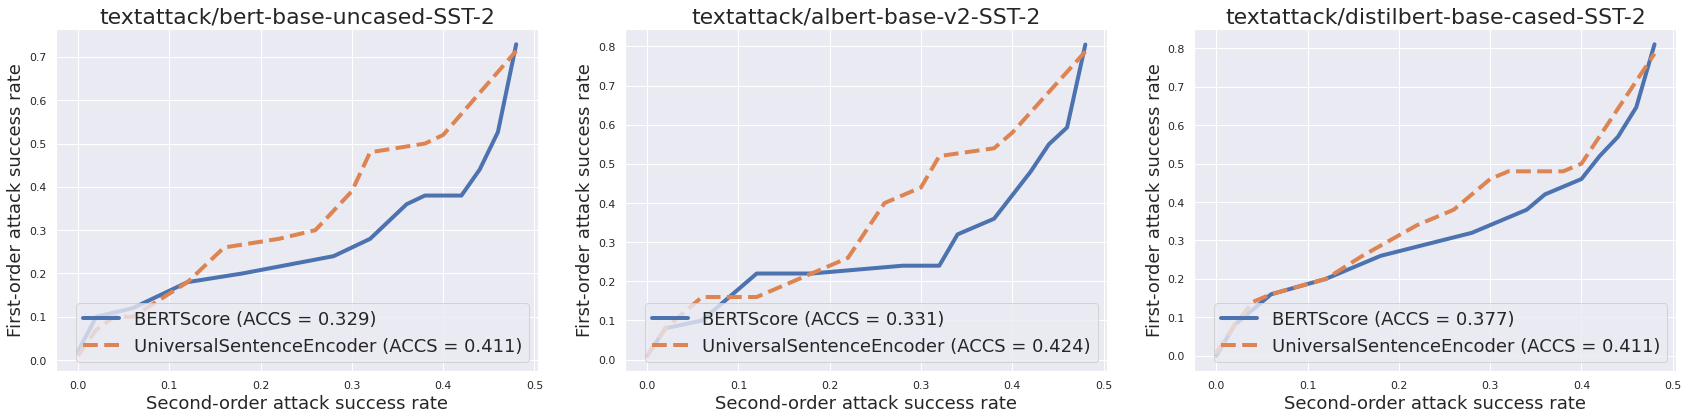

In [7]:
##
## PLOT AUC AND STUFF
##

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

sns.set()

second_order_df = pd.DataFrame(data) \
                    .rename(columns={'num_successes': 'num_second_order_successes'}) \
                    .drop('num_words_to_swap', axis=1)
first_order_df = pd.DataFrame(data2) \
                    .rename(columns={'num_successes': 'num_first_order_successes'})

full_df = pd.merge(first_order_df, second_order_df)

df_models = full_df['model'].unique()
fig, ax = plt.subplots(1, len(df_models), figsize=(24, 6))

for model_idx, model in enumerate(df_models):
  df = full_df[full_df['model'] == model].reset_index()
  # Add datapoints where eps=1.0 and success rate is zero, instead of actually running
  # futile attacks.
  for constraint in df['constraint'].unique():
    zero_data_point = df[df['constraint'] == constraint] \
                         [df['num_first_order_successes'] == 0.0] \
                         [df['num_second_order_successes'] == 0.0]
    if zero_data_point.empty:
      extra_data_point = { 'constraint': constraint, 'num_first_order_successes': 0.0, 'num_second_order_successes': 0.0 } # The \eps=1.0 datapoint
      extra_data_point_row = [extra_data_point.get(c) for c in df.columns]
      df.loc[-1] = extra_data_point_row # add row
      df.index = df.index + 1  # shifting index
      df.sort_index(inplace=True) 

  # Calculate rate in terms of num successes
  df['first_order_success_rate'] = df['num_first_order_successes'] / num_samples
  df['second_order_success_rate'] = df['num_second_order_successes'] / num_samples

  labels = []
  # Calculate AUC.
  for constraint in df['constraint'].unique():
    x = df[df['constraint'] == constraint]['second_order_success_rate']
    y = df[df['constraint'] == constraint]['first_order_success_rate']
    auc = sklearn.metrics.auc(x, y)
    accs = auc / (max(x) * max(y))
    print(constraint)
    print(f'--> AUC: {auc}')
    print(f'--> ACCS: {accs}')
    
    labels.append(f'{constraint} (ACCS = {accs:.3f})')
  print('labels', labels)
  # Plot curve.
  sns.lineplot(df['second_order_success_rate'], df['first_order_success_rate'], 
                hue=df['constraint'], ci=0, ax=ax[model_idx], lw=4)

  ax[model_idx].get_lines()[1].set_linestyle('--')
  
  ax[model_idx].legend(labels, loc=4, prop={'size': 18}) # bottom right, see https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.legend.html
  ax[model_idx].set_title(model, fontsize=22)
  ax[model_idx].set_xlabel('Second-order attack success rate', fontsize=18)
  ax[model_idx].set_ylabel('First-order attack success rate',  fontsize=18)
  # ax[model_idx].set_xlabel('')
  # ax[model_idx].set_ylabel('')

plt.tight_layout()
plt.savefig('attack_curve_sst2.pdf')

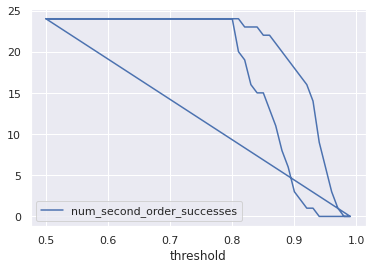

In [8]:
df.plot(x='threshold', y='num_second_order_successes')

models ->  ['textattack/bert-base-uncased-SST-2' 'textattack/albert-base-v2-SST-2'
 'textattack/distilbert-base-cased-SST-2']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


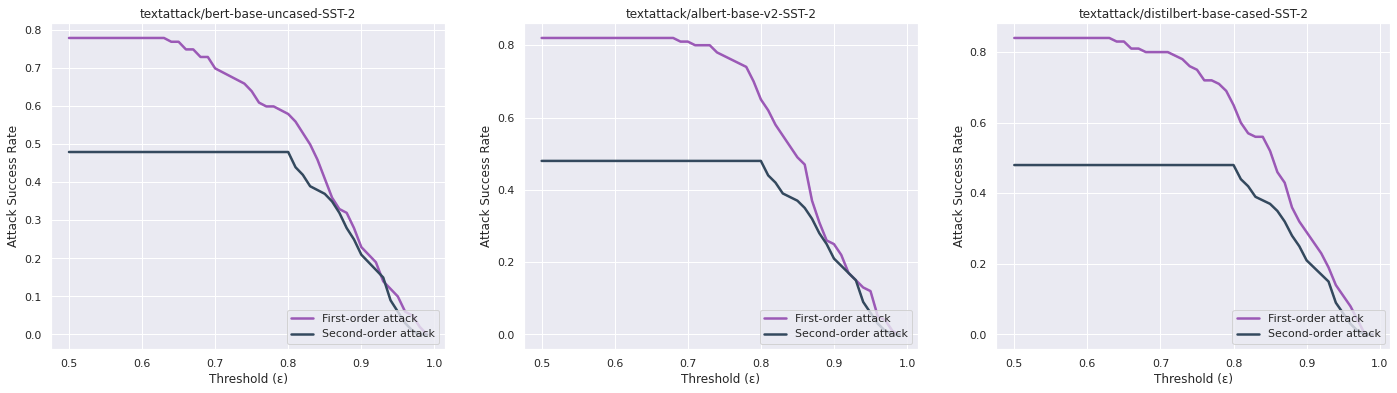

In [9]:
##
## PLOT ATTACK SUCCESS AND STUFF
##

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

df_models = full_df['model'].unique()
fig, ax = plt.subplots(1, len(df_models), figsize=(24, 6))

LINE_WIDTH = 2.5    # thickish
COLOR_1 = "#9b59b6" # purplish
COLOR_2 = "#34495e" # blackish

print('models -> ', df_models)
for model_idx, model in enumerate(df_models):
  df = full_df[full_df['model'] == model].reset_index()

  # Calculate rate in terms of num successes
  df['first_order_success_rate'] = df['num_first_order_successes'] / num_samples
  df['second_order_success_rate'] = df['num_second_order_successes'] / num_samples
  
  # Add datapoints where eps=1.0 and success rate is zero, instead of actually running
  # futile attacks.
  for constraint in df['constraint'].unique():
    zero_data_point = df[df['constraint'] == constraint] \
                         [df['num_first_order_successes'] == 0.0] \
                         [df['num_second_order_successes'] == 0.0]
    if zero_data_point.empty:
      extra_data_point = { 'constraint': constraint, 'num_first_order_successes': 0.0, 'num_second_order_successes': 0.0 } # The \eps=1.0 datapoint
      extra_data_point_row = [extra_data_point.get(c) for c in df.columns]
      df.loc[-1] = extra_data_point_row # add row
      df.index = df.index + 1  # shifting index
      df.sort_index(inplace=True)

  # Plot curve.
  sns.lineplot(df['threshold'].astype(float), df['first_order_success_rate'].astype(float), 
                color=COLOR_1, ci=0, lw=LINE_WIDTH, ax=ax[model_idx])
  
  sns.lineplot(df['threshold'].astype(float), df['second_order_success_rate'].astype(float), 
                color=COLOR_2, ci=0, lw=LINE_WIDTH, ax=ax[model_idx])
  
  # ax[model_idx].get_lines()[-1].set_linestyle('--')
  ax[model_idx].legend(['First-order attack', 'Second-order attack'], loc=4) # bottom right, see https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.legend.html
  ax[model_idx].set_title(model)

  ax[model_idx].set_xlabel('Threshold (ε)')
  ax[model_idx].set_ylabel('Attack Success Rate')

  # plt.xlabel('Second-order attack success rate')
  # plt.ylabel('First-order attack success rate')
  # plt.title('SNLI')
  plt.savefig('attack_successes_sst2.pdf')